#A Birdsong classifier for selected species found in Iceland.

---


```
# Project in Deep Neural Networks, RAF117F at University of Iceland
# Author: Elías Bjartur Einarsson with help and inspiration from Karl Birkir Flosason
```



#Inngangur

## Import

In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Dropout, Input, Activation, MaxPooling2D, SimpleRNN, LSTM, GRU
from keras.models import Model, Sequential
import keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix

!pip install visualkeras --upgrade
import visualkeras
from collections import defaultdict
color_map = defaultdict(dict)
color_map[Input]['fill'] = 'gold'
color_map[Conv2D]['fill'] = 'paleturquoise'
color_map[MaxPooling2D]['fill'] = 'indianred'
color_map[Dense]['fill'] = 'deepskyblue'
color_map[Flatten]['fill'] = 'slategray'

## Functions

In [2]:
íslenska = ["Heiðlóa", "Spói", "Hrossagaukur", "Kría", "Álft", "Grágæs", "Hrafn", "Stari",
"Skógarþröstur", "Maríuerla", "Tjaldur", "Sílamáfur", "Svartþröstur"]

latína = ["Pluvialis+apricaria", "Numenius+phaeopus", "Gallinago+gallinago",
"Sterna+paradisaea", "Cygnus+cygnus", "Anser+anser", "Corvus+corax",
"Sturnus+vulgaris", "Turdus+iliacus", "Motacilla+alba",
"Haematopus+ostralegus", "Larus+fuscus",  "Turdus+merula"]

enska = ["European Golden Plover", "Whimbrel", "Common Snipe", "Arctic Tern",
"Whooper Swan", "Greylag Goose", "Northern Raven", "Common Starling",
"Redwing","White Wagtail", "Eurasian Oystercatcher", "Lesser Black-backed Gull",
"Common Blackbird"]

latIsl = dict(zip(latína, íslenska))
latEn = dict(zip(latína, enska))

In [3]:
# Lengd þjálfunardæma
num_columns = 20 

In [4]:
# Sækja gamlar keyrslur eður ei?
reload = True

In [5]:
def TrainSplit(num_columns, val_ratio=0.1, test_ratio=0.1, verbose=False):
  # Setja saman stokkað þjálfunarsafn 
  dir = '/content/drive/My Drive/Colab Notebooks/Fuglar/'
  os.chdir(dir)

  with open("Gogn.json") as f:
      Gögn = json.loads(f.read()) 

  tegundir = latína
  # ['Anser+anser', 'Corvus+corax', 'Cygnus+cygnus', 'Gallinago+gallinago']

  IDtoSpecie = {}    # Heldur utan um flokk hverrar upptöku út frá ID/nafni hennar
  totalNrClips = 0   # Heildarfjöldinn sem unnið er með

  catagorie = []
  filePaths = []
  IDs = []
  for tegund in tegundir:
    if verbose:
      print('Meðhöndla ' + latIsl[tegund])
    recCount = len(Gögn[tegund])
    totalNrClips += recCount
    ofStutt = 0
    for i in range(recCount):
        if Gögn[tegund][i]['shortRecLen'] < num_columns:
            ofStutt += 1
            continue
        catagorie.append(tegund) 
        filePaths.append(Gögn[tegund][i]["path"])
        IDs.append(Gögn[tegund][i]["id"])
    totalNrClips -= ofStutt
    if verbose:
      print('Búinn með ' + str(recCount - ofStutt) + ' af ' + latIsl[tegund])
        
  NumToSpecie, catagories_list = np.unique(catagorie, return_inverse=True) # ath úttak
  catagories_list = catagories_list + 1
  NumToSpecie = np.insert(NumToSpecie, 0, 'Unknown')
  SpecieToNum = (dict(zip(NumToSpecie, range(len(NumToSpecie)))))
  for i in range(totalNrClips):
      IDtoSpecie[IDs[i]] = catagories_list[i]

  if verbose:
    print('heildarfjöldi: ' + str(totalNrClips))

  # Stokkun
  rng = np.random.default_rng(seed=1)
  perm = rng.permutation(len(catagorie))
  catagorie = [catagorie[x] for x in perm]
  catagories_list = [catagories_list[x] for x in perm]
  filePaths = [filePaths[x] for x in perm]
  IDs = [IDs[x] for x in perm]

  # Þjálfunarskipting
  train_ratio = 1 - val_ratio - test_ratio
  numTrain = int(train_ratio*len(IDs))
  numVal = int(val_ratio*len(IDs))
  X_train = IDs[:numTrain]
  X_val = IDs[numTrain:numTrain+numVal]
  X_test = IDs[numTrain+numVal:]

  return X_train, X_val, X_test, NumToSpecie, SpecieToNum, IDtoSpecie

In [6]:
X_train, X_val, X_test, NumToSpecie, SpecieToNum, IDtoSpecie = TrainSplit(num_columns=num_columns)

In [7]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Fuglar/')
from CNNdatagenerator import DataGenerator

dimensions = (128,num_columns)
classes = len(NumToSpecie)

training_generator = DataGenerator(X_train, labels=IDtoSpecie, dim=dimensions, n_classes=classes, columns=num_columns)
val_generator = DataGenerator(X_val, labels=IDtoSpecie, dim=dimensions, n_classes=classes, columns=num_columns)
test_generator = DataGenerator(X_test, labels=IDtoSpecie, dim=dimensions, n_classes=classes, columns=num_columns, shuffle=False)

In [8]:
# Fall til að sýna gang þjálfunar
def plotHistory(history, metrics=['auc', 'precision', 'accuracy', 'recall'], save=False, metric_title=None, loss_title=None):
  try:
    history = history.history
  except:
    pass
  
  legend = []
  if 'auc' in metrics:
    plt.plot(history['auc'])
    plt.plot(history['val_auc'])
    legend.append('AUC')
    legend.append('Val. AUC')
  if 'precision' in metrics:
    plt.plot(history['precision'])
    plt.plot(history['val_precision'])
    legend.append('Precision')
    legend.append('Val. Precision')
  if 'accuracy' in metrics:
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    legend.append('Accuracy')
    legend.append('Val. accuracy')
  if 'recall' in metrics:
    plt.plot(history['recall'])
    plt.plot(history['val_recall'])
    legend.append('Recall')
    legend.append('Val. recall')

  plt.ylabel('Measure')
  plt.xlabel('Epoch')

  plt.legend(legend)
  if save:
    plt.savefig(metric_title, dpi=300)
  plt.show()

  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'])
  if save:
    plt.savefig(loss_title, dpi=300)
  plt.show()

In [9]:
# Fall til að sýna confusion matrix
# Original author: @bninopaul at Stackoverflow.com
def confMat(array, save=False, title=None):
  import seaborn as sn
  import pandas as pd
  import matplotlib.pyplot as plt
  df_cm = pd.DataFrame(array, index = [latEn[i] for i in NumToSpecie[1:]],
                    columns = [latEn[i] for i in NumToSpecie[1:]])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.1%')
  if save:
    plt.savefig(title, dpi=300, bbox_inches='tight') 

In [10]:
# Fall til að sýna classification report
# Original author: @bin at Stackoverflow.com
def plot_classification_report(cr, with_avg_total=False, cmap=plt.cm.Blues, save=False, title='Classification report'):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        #print(line)
        t = line.split()
        #print(t)
        classes.append(t[0]) 
        v = [float(x) for x in t[1: len(t) - 1]]
        #print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=90)
    plt.yticks(y_tick_marks, [latEn[NumToSpecie[int(x)]] for x in classes]) 
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    if save:
      plt.savefig(title, dpi=300, bbox_inches='tight') 

#Models

## Baseline Model

### Definition and fitting

In [11]:
def BaseModel(input_shape, output_shape):
  
  X_input = Input(input_shape)
  X = Flatten()(X_input)
  X = Dense(output_shape, activation='softmax')(X)

  model = Model(inputs=X_input, outputs=X, name='BaseModel')

  return model

Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 20, 1)]      0         
_________________________________________________________________
flatten (Flatten)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                35854     
Total params: 35,854
Trainable params: 35,854
Non-trainable params: 0
_________________________________________________________________


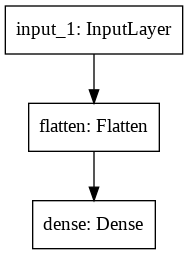

In [12]:
base = BaseModel((128,num_columns,1), len(NumToSpecie))
base.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['AUC', 'accuracy', 'Precision', 'Recall']) 
base.summary()
keras.utils.plot_model(base)

In [13]:
if not reload:
  basehistory = base.fit(training_generator, validation_data=val_generator, epochs=40)

  np.save('basehistory.npy',basehistory.history)
  base.save('basemodel')
  base.save_weights('base_weights.npy')

### Assesment

In [ ]:
if reload:
  basehistory = np.load('basehistory.npy', allow_pickle=True).item()
  base = keras.models.load_model('basemodel')

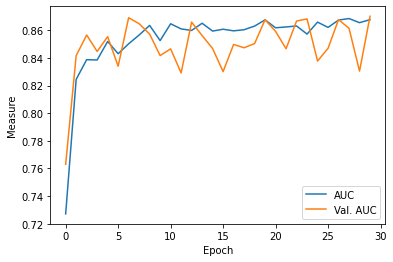

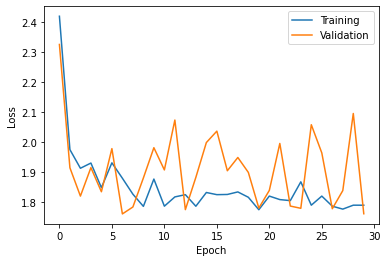

In [ ]:
plotHistory(basehistory, metrics=['accuracy'], save=True, metric_title='Base_metrics.jpg', loss_title='Base_loss.jpg')

In [ ]:
# Confusion matrix og aðrar mælingar

yhat = base.predict(test_generator) 
yhat = np.argmax(yhat, axis=1)


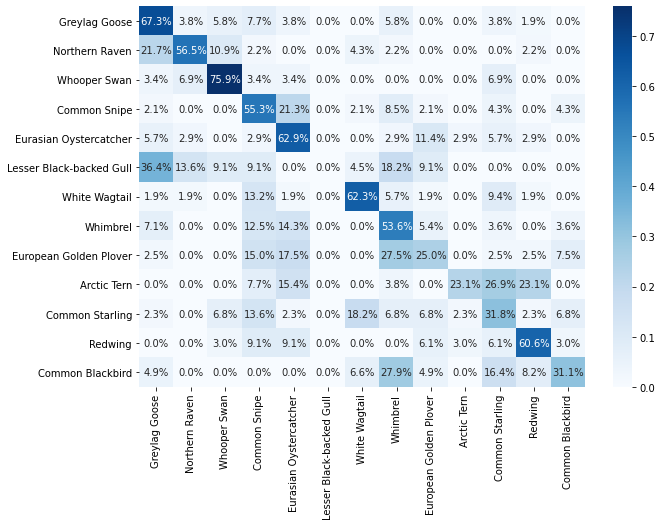

In [ ]:
ytrue = [IDtoSpecie[x] for x in X_test[:544]] 

confmatrix = confusion_matrix(ytrue, yhat, normalize='true')
confMat(confmatrix, save=False, title='Base_confMat.jpg')

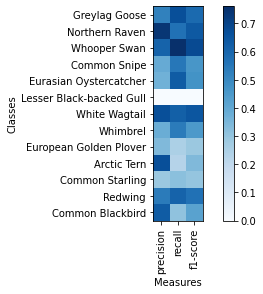

In [ ]:
classRep = classification_report(ytrue, yhat, zero_division=0 ) 
plot_classification_report(classRep, save=False, title='Base_classRep.jpg')

In [ ]:
base_evaluation = base.evaluate(test_generator)
print(base_evaluation)

17/17 [==============================] - 1s 59ms/step - loss: 1.6193 - auc: 0.8953 - accuracy: 0.4706 - precision: 0.6567 - recall: 0.2812
[1.6193177700042725, 0.8953219652175903, 0.47058823704719543, 0.6566523313522339, 0.28125]


###Visualisation

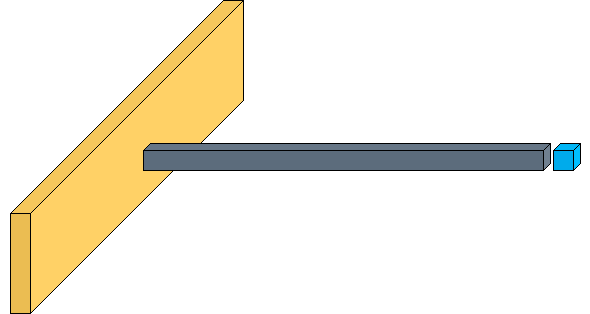

In [ ]:
visualkeras.layered_view(base, color_map=color_map, scale_xy=5, scale_z=1, draw_volume=True, draw_funnel=False, to_file='base_visual.png')

##CNN model

### Definition and fitting

In [ ]:
def CNN_BirdNet(input_shape, output_shape):

    X_input = Input(input_shape)

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), (2,2), name='max_pool0')(X)
    
    # CONV -> RELU Block 
    X = Conv2D(32, (3, 3), strides = (1, 1), padding = 'same', name = 'conv1a')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # CONV -> RELU Block 
    X = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', name = 'conv1b')(X)
    X = BatchNormalization(axis = -1, name = 'bn1b')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), (2, 2), name='max_pool1')(X)
    
    # CONV -> RELU Block 
    X = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same', name = 'conv2a')(X)
    X = BatchNormalization(axis = -1, name = 'bn2')(X)
    X = Activation('relu')(X)

    # CONV -> RELU Block 
    X = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same', name = 'conv3b')(X)
    X = BatchNormalization(axis = -1, name = 'bn3b')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), (2, 2), name='max_pool3')(X)

    # FLATTEN X 
    X = Flatten()(X)

    # FULLY CONNECTED
    X = Dense(256, activation='relu', name='fc0')(X)
    X = Dropout(0.5)(X)

    # FULLY CONNECTED
    X = Dense(64, activation='relu', name='fc1')(X)
    X = Dropout(0.5)(X)

    # FULLY CONNECTED
    X = Dense(output_shape, activation='softmax', name='fc2')(X) # Athuga output_shape + 1, fyrir núll fremst?

    # CREATE MODEL
    model = Model(inputs = X_input, outputs = X, name='CNN_BirdNet')
    
    return model


In [ ]:
input_shape = (128,num_columns,1)
CNNmodel = CNN_BirdNet(input_shape, len(NumToSpecie))
CNNmodel.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['AUC', 'accuracy', 'Precision', 'Recall']) 
CNNmodel.summary()

Model: "CNN_BirdNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 20, 1)]      0         
_________________________________________________________________
conv0 (Conv2D)               (None, 128, 20, 16)       160       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 128, 20, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 128, 20, 16)       0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 64, 10, 16)        0         
_________________________________________________________________
conv1a (Conv2D)              (None, 64, 10, 32)        4640      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 64, 10, 32)        

In [ ]:
if not reload:
  CNNhistory = CNNmodel.fit(training_generator, 
                      epochs=40, 
                      validation_data=val_generator,
                      verbose=1)

  np.save('CNNhistory.npy',CNNhistory.history)
  CNNmodel.save('CNNmodel')
  CNNmodel.save_weights('CNNmodel_weights.npy')

### Assessment

In [ ]:
if reload:
  os.chdir('/content/drive/My Drive/Colab Notebooks/Fuglar/')
  CNNhistory = np.load('CNNhistory.npy',allow_pickle='TRUE').item()
  CNNmodel = keras.models.load_model('CNNmodel')

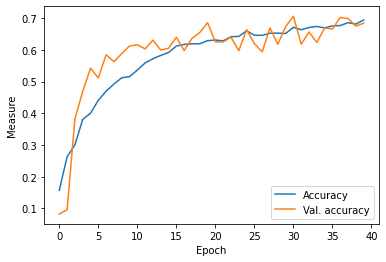

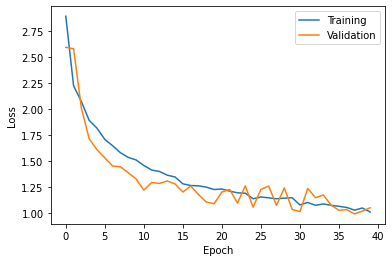

In [ ]:
plotHistory(CNNhistory, metrics=['accuracy'], save=False, metric_title='CNN_metrics.jpg', loss_title='CNN_loss.jpg')

In [ ]:
# Confusion matrix og Classification report

yhat = CNNmodel.predict(test_generator) 
yhat = np.argmax(yhat, axis=1)
ytrue = [IDtoSpecie[x] for x in X_test[:544]] 

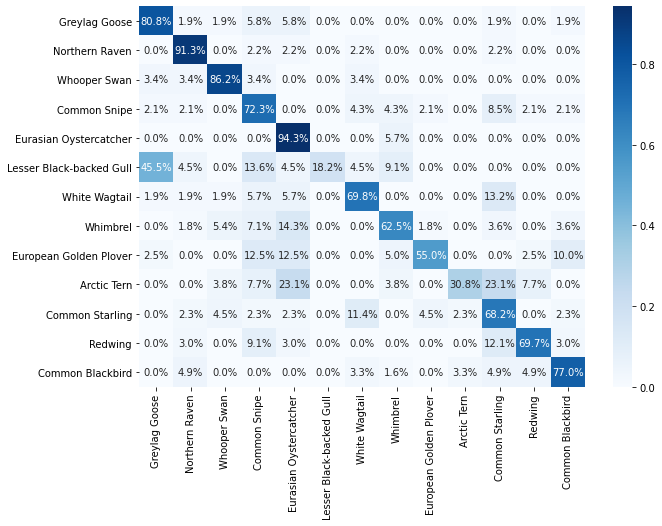

In [ ]:
confmatrix = confusion_matrix(ytrue, yhat, normalize='true')
confMat(confmatrix, save=False, title='CNN_confMat.jpg')

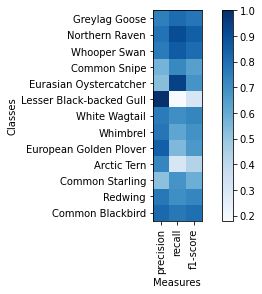

In [ ]:
classRep = classification_report(ytrue, yhat) 

plot_classification_report(classRep, save=False, title='CNN_classRep.jpg')

In [ ]:
evaluation = CNNmodel.evaluate(test_generator)

17/17 [==============================] - 1s 65ms/step - loss: 0.9613 - auc: 0.9575 - accuracy: 0.7261 - precision: 0.8837 - recall: 0.5864


###Visualisation

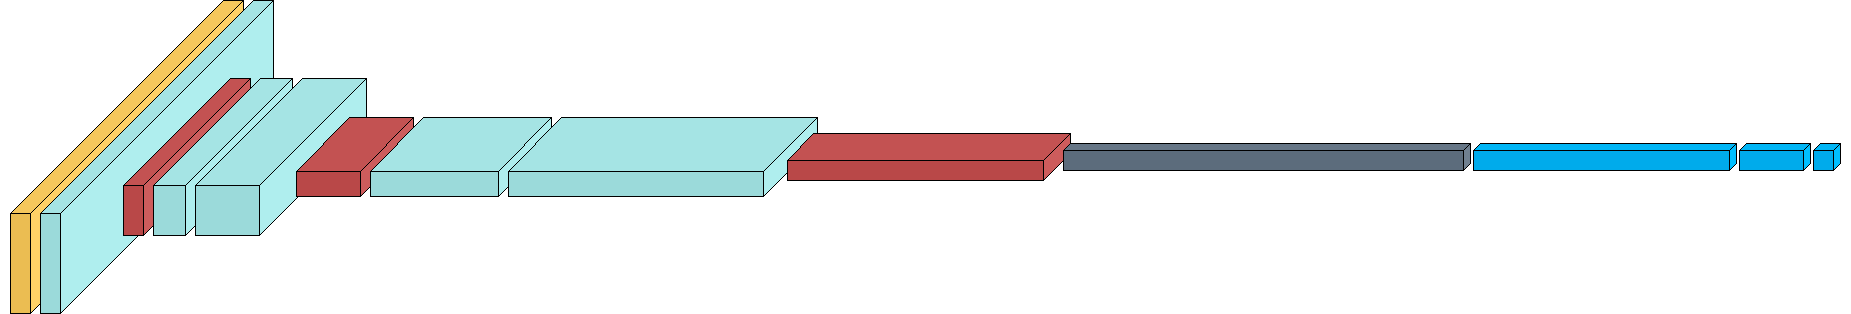

In [ ]:
visualkeras.layered_view(CNNmodel, color_map=color_map, to_file='CNN_visualkeras.png', scale_xy=5, scale_z=1, type_ignore=[BatchNormalization, Activation, Dropout], draw_volume=True, draw_funnel=False)

## RNN model

###Definition and fitting

In [ ]:
def RNN_BirdNet(input_shape, output_shape):

  rnnModel = Sequential()
  rnnModel.add(LSTM(128, input_shape=input_shape, dropout=0.7))
  rnnModel.add(Dense(output_shape, activation='softmax'))
  
  return rnnModel


In [ ]:

RNN_model = RNN_BirdNet((None, 128), len(NumToSpecie))
RNN_model.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['AUC', 'accuracy', 'Precision', 'Recall'])
RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1806      
Total params: 133,390
Trainable params: 133,390
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Hér þarf annan data generator til að víddirnar passi fyrir RNN
os.chdir('/content/drive/My Drive/Colab Notebooks/Fuglar/')
from RNNdatagenerator import DataGenerator

dimensions = (128,num_columns)
classes = len(NumToSpecie)

rnn_training_generator = DataGenerator(X_train, labels=IDtoSpecie, dim=dimensions, n_classes=classes, columns=num_columns)
rnn_val_generator = DataGenerator(X_val, labels=IDtoSpecie, dim=dimensions, n_classes=classes, columns=num_columns)
rnn_test_generator = DataGenerator(X_test, labels=IDtoSpecie, dim=dimensions, n_classes=classes, columns=num_columns, shuffle=False)

In [ ]:
if not reload:
  rnnHistory = RNN_model.fit(rnn_training_generator, validation_data=rnn_val_generator, epochs=40)

  np.save('rnnhistory.npy',rnnHistory.history)
  RNN_model.save('RNN_model')
  RNN_model.save_weights('RNN_model_weights.npy')

Epoch 1/40
137/137 [==============================] - 12s 89ms/step - loss: 1.9147 - auc: 0.8394 - accuracy: 0.3789 - precision: 0.6803 - recall: 0.1102 - val_loss: 1.6513 - val_auc: 0.8859 - val_accuracy: 0.4375 - val_precision: 0.6515 - val_recall: 0.2371
Epoch 2/40
137/137 [==============================] - 11s 79ms/step - loss: 1.6086 - auc: 0.8921 - accuracy: 0.4608 - precision: 0.6925 - recall: 0.2543 - val_loss: 1.6169 - val_auc: 0.8905 - val_accuracy: 0.4688 - val_precision: 0.6236 - val_recall: 0.3107
Epoch 3/40
137/137 [==============================] - 11s 78ms/step - loss: 1.5360 - auc: 0.9017 - accuracy: 0.4970 - precision: 0.6993 - recall: 0.2929 - val_loss: 1.5632 - val_auc: 0.8970 - val_accuracy: 0.4963 - val_precision: 0.6947 - val_recall: 0.3346
Epoch 4/40
137/137 [==============================] - 11s 80ms/step - loss: 1.4811 - auc: 0.9095 - accuracy: 0.5059 - precision: 0.7227 - recall: 0.3168 - val_loss: 1.5186 - val_auc: 0.9022 - val_accuracy: 0.5000 - val_precisi

### Assessment

In [ ]:
if reload:
  os.chdir('/content/drive/My Drive/Colab Notebooks/Fuglar/')
  rnnHistory = np.load('rnnhistory.npy',allow_pickle='TRUE').item()
  RNN_model = keras.models.load_model('RNN_model')

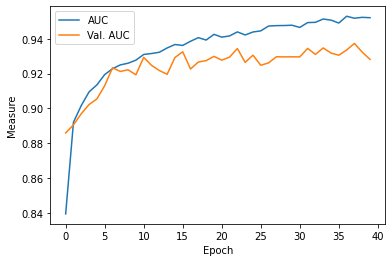

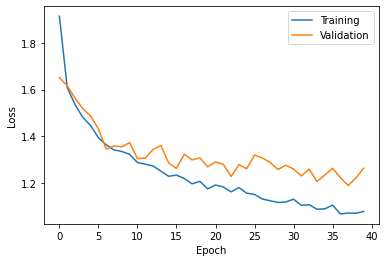

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 14)                1806      
Total params: 133,390
Trainable params: 133,390
Non-trainable params: 0
_________________________________________________________________


In [ ]:
plotHistory(rnnHistory, metrics=['accuracy'], save=True, metric_title='RNN_metrics.jpg', loss_title='RNN_loss.jpg')
RNN_model.summary()

In [ ]:
results = RNN_model.evaluate(rnn_test_generator, batch_size=32)

17/17 [==============================] - 1s 87ms/step - loss: 1.2970 - auc_2: 0.9279 - accuracy: 0.5772 - precision_2: 0.7757 - recall_2: 0.4577
test loss, auc, acc, pre, rec: [1.2970315217971802, 0.9278674125671387, 0.5772058963775635, 0.7757009267807007, 0.4577205777168274]


In [ ]:
# Confusion matrix og aðrar mælingar
from sklearn.metrics import classification_report, confusion_matrix

yhat = RNN_model.predict(rnn_test_generator) 
yhat = np.argmax(yhat, axis=1)
ytrue = [IDtoSpecie[x] for x in X_test[:544]] 

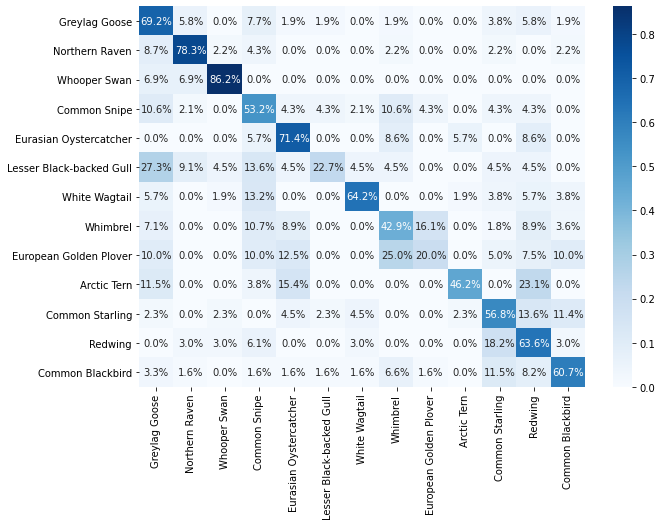

In [ ]:
confmatrix = confusion_matrix(ytrue, yhat, normalize='true')
confMat(confmatrix, save=True, title='RNN_confMat.jpg')

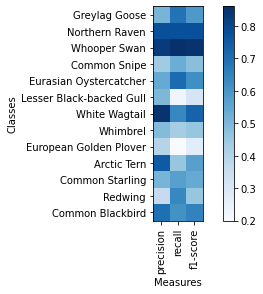

In [ ]:
classRep = classification_report(ytrue, yhat) 
plot_classification_report(classRep, save=True, title='RNN_classRep.jpg')

## Densenet 121

### Definition and fitting

In [ ]:
input_shape = (128, 32, 1)
X_input = Input(input_shape)

denseNet121 = tf.keras.applications.DenseNet121(
    include_top=True, # síðasta Dense lagið
    weights=None,
    input_tensor=X_input,
    input_shape=input_shape,
    pooling=max,
    classes=len(NumToSpecie), 
)


In [ ]:
denseNet121.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['AUC', 'accuracy', 'Precision', 'Recall']) 
#denseNet121.summary()

In [ ]:
columns = 32 # Minimum amount for Densenet
X_train_Dense, X_val_Dense, X_test_Dense, NumToSpecie_Dense, SpecieToNum_Dense, IDtoSpecie_Dense = TrainSplit(num_columns=columns)

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Fuglar/')
from CNNdatagenerator import DataGenerator

dimensions = (128,num_columns)
classes = len(NumToSpecie_Dense)

Dense_training_generator = DataGenerator(X_train_Dense, labels=IDtoSpecie_Dense, dim=dimensions, n_classes=classes, columns=columns)
Dense_val_generator = DataGenerator(X_val_Dense, labels=IDtoSpecie_Dense, dim=dimensions, n_classes=classes, columns=columns)
Dense_test_generator = DataGenerator(X_test_Dense, labels=IDtoSpecie_Dense, dim=dimensions, n_classes=classes, columns=columns, shuffle=False)

In [ ]:
if not reload:
  dense_history = denseNet121.fit(Dense_training_generator, validation_data=Dense_val_generator, epochs=40)
  np.save('densehistory.npy',dense_history.history)
  denseNet121.save_weights('denseNet121_weights.npy')

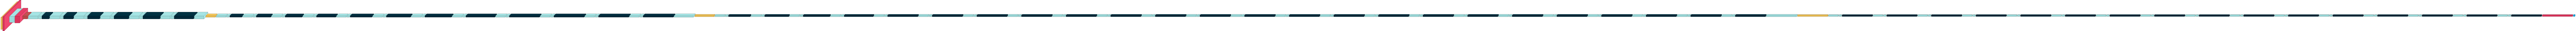

In [ ]:
visualkeras.layered_view(denseNet121, color_map=color_map, to_file='Dense_visualkeras.png', scale_xy=5, scale_z=1, type_ignore=[BatchNormalization, Activation, Dropout], draw_volume=True, draw_funnel=False)

### Assessment

In [ ]:
if reload:
  densehistory = np.load('densehistory.npy', allow_pickle=True).item()
  denseNet121.load_weights('denseNet121_weights.npy')

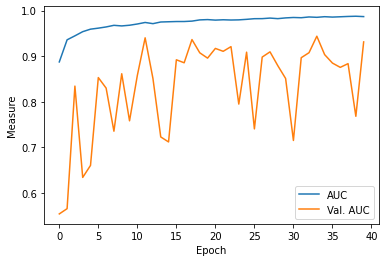

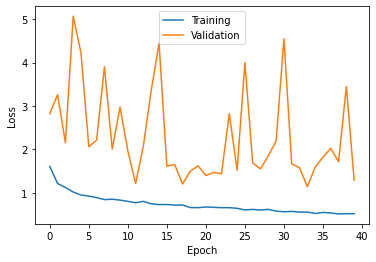

In [ ]:
plotHistory(densehistory, metrics=['accuracy'], save=True, metric_title='Dense_metrics.jpg', loss_title='Dense_loss.jpg')

In [ ]:
# Confusion matrix og aðrar mælingar
from sklearn.metrics import classification_report, confusion_matrix

yhat = denseNet121.predict(Dense_test_generator) 
yhat = np.argmax(yhat, axis=1)
ytrue = [IDtoSpecie[x] for x in X_test_Dense[:512]] 

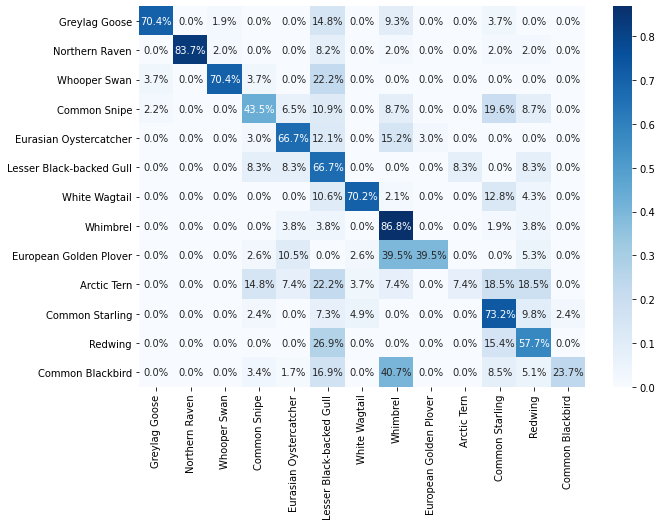

In [ ]:
confmatrix = confusion_matrix(ytrue, yhat, normalize='true')
confMat(confmatrix, save=True, title='Dense_confMat.jpg')

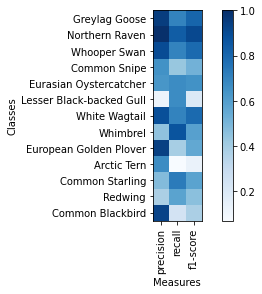

In [ ]:
classRep = classification_report(ytrue, yhat) 

plot_classification_report(classRep, save=True, title='Dense_classRep.jpg')

In [ ]:
eval = denseNet121.evaluate(Dense_test_generator)

16/16 [==============================] - 527s 33s/step - loss: 1.4777 - auc: 0.9169 - accuracy: 0.5645 - precision: 0.6832 - recall: 0.5098
